In [0]:
#import necessary modules
import pandas as pd

#visualization modules
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

#moseling modules
import tensorflow as tf

In [0]:
# start and implement a spark session 
from pyspark.sql import SparkSession
from pyspark import SparkFiles
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [0]:
#grab all data URLS to be needed for processing
#=======
#weather datasets URL
maxtemp_url = "https://raw.githubusercontent.com/LYITBDAI/bd2022/main/tMax_Global.csv"
mintemp_url = "https://raw.githubusercontent.com/LYITBDAI/bd2022/main/tMin_Global.csv"
#covid URL
owd_all_data = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"

In [0]:
## PULL ALL DATA FILES INTO SPARK

spark.sparkContext.addFile(maxtemp_url)
spark.sparkContext.addFile(mintemp_url)
spark.sparkContext.addFile(owd_all_data)

#weather DFs
max_temp_df = spark.read.csv("file://"+SparkFiles.get("tMax_Global.csv"), header=True, inferSchema=True)
min_temp_df = spark.read.csv("file://"+SparkFiles.get("tMin_Global.csv"), header=True, inferSchema=True)

#COVID DFs
owd_data_full = spark.read.csv("file://"+SparkFiles.get("owid-covid-data.csv"), header=True, inferSchema=True)

In [0]:
#INSPECT DATA 
owd_data_full.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161909 entries, 0 to 161908
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    161909 non-null  object 
 1   continent                                   152200 non-null  object 
 2   location                                    161909 non-null  object 
 3   date                                        161909 non-null  object 
 4   total_cases                                 158958 non-null  float64
 5   new_cases                                   158930 non-null  float64
 6   new_cases_smoothed                          157779 non-null  float64
 7   total_deaths                                141289 non-null  float64
 8   new_deaths                                  141461 non-null  float64
 9   new_deaths_smoothed                         141331 non-null  float64
 

In [0]:
##DROP UNDEEDED COLUMN AND FEATURES

world_daily_new_cases_data = owd_data_full["location", "date", "new_cases"]
world_daily_new_cases_data


Out[93]: DataFrame[location: string, date: string, new_cases: double]

In [0]:
##SEPERATE DATA INTO YEAR FRAMES 
pattern2 = '2020'
dailynewcases_2020_data = world_daily_new_cases_data.filter(world_daily_new_cases_data.date.rlike(pattern2))
dailynewcases_2020_data.show(5)

+-----------+----------+---------+
|   location|      date|new_cases|
+-----------+----------+---------+
|Afghanistan|2020-02-24|      5.0|
|Afghanistan|2020-02-25|      0.0|
|Afghanistan|2020-02-26|      0.0|
|Afghanistan|2020-02-27|      0.0|
|Afghanistan|2020-02-28|      0.0|
+-----------+----------+---------+
only showing top 5 rows



In [0]:
##PERFORM FURTHER CLEANING AFTER INSPECTION
dailynewcases_2020_data = dailynewcases_2020_data.filter(dailynewcases_2020_data.location != "World")
dailynewcases_2020_data = dailynewcases_2020_data.filter(dailynewcases_2020_data.location != "International")
dailynewcases_2020_data = dailynewcases_2020_data.filter(dailynewcases_2020_data.location != "Asia")
dailynewcases_2020_data = dailynewcases_2020_data.filter(dailynewcases_2020_data.location != "High income")
dailynewcases_2020_data = dailynewcases_2020_data.filter(dailynewcases_2020_data.location != "Lower middle income")
dailynewcases_2020_data = dailynewcases_2020_data.filter(dailynewcases_2020_data.location != "Upper middle income")
dailynewcases_2020_data = dailynewcases_2020_data.filter(dailynewcases_2020_data.location != "Europe")
dailynewcases_2020_data = dailynewcases_2020_data.filter(dailynewcases_2020_data.location != "European Union")
dailynewcases_2020_data = dailynewcases_2020_data.filter(dailynewcases_2020_data.location != "North America")
dailynewcases_2020_data = dailynewcases_2020_data.filter(dailynewcases_2020_data.location != "Africa")
dailynewcases_2020_data = dailynewcases_2020_data.filter(dailynewcases_2020_data.location != "South America")




dailynewcases_2020_data.show(4)

+-----------+----------+---------+
|   location|      date|new_cases|
+-----------+----------+---------+
|Afghanistan|2020-02-24|      5.0|
|Afghanistan|2020-02-25|      0.0|
|Afghanistan|2020-02-26|      0.0|
|Afghanistan|2020-02-27|      0.0|
+-----------+----------+---------+
only showing top 4 rows



In [0]:
## FILTER DATA INTO SEASONS FRAMES
copy_df_2020 = dailynewcases_2020_data
winter_data_2020 = copy_df_2020.filter(copy_df_2020.date.between('2020-02-24','2020-02-31'))
spring_data_2020 = copy_df_2020.filter(copy_df_2020.date.between('2020-03-01','2020-05-31'))
summer_data_2020 = copy_df_2020.filter(copy_df_2020.date.between('2020-06-01','2020-08-31'))
autumn_data_2020 = copy_df_2020.filter(copy_df_2020.date.between('2020-09-01','2020-11-31'))

winter_data_2020.show()

+-----------+----------+---------+
|   location|      date|new_cases|
+-----------+----------+---------+
|Afghanistan|2020-02-24|      5.0|
|Afghanistan|2020-02-25|      0.0|
|Afghanistan|2020-02-26|      0.0|
|Afghanistan|2020-02-27|      0.0|
|Afghanistan|2020-02-28|      0.0|
|Afghanistan|2020-02-29|      0.0|
|    Albania|2020-02-25|     null|
|    Albania|2020-02-26|     null|
|    Albania|2020-02-27|     null|
|    Albania|2020-02-28|     null|
|    Albania|2020-02-29|     null|
|    Algeria|2020-02-25|      1.0|
|    Algeria|2020-02-26|      0.0|
|    Algeria|2020-02-27|      0.0|
|    Algeria|2020-02-28|      0.0|
|    Algeria|2020-02-29|      0.0|
|  Argentina|2020-02-24|     null|
|  Argentina|2020-02-25|     null|
|  Argentina|2020-02-26|     null|
|  Argentina|2020-02-27|     null|
+-----------+----------+---------+
only showing top 20 rows



In [0]:
### REDUCE SEASON FRAMES BY MAKING A SUM OF DATA ACROSS SEASONS FOR THE YEAR
import pyspark.sql.functions as sf

# cummulative_winter_newcases_by_2020 = winter_data_2020.groupby(winter_data_2020.columns[0]).sum()
cummulative_winter_newcases_by_2020 = winter_data_2020.groupby("location").agg(sf.sum('new_cases').alias('cummulative'))
cummulative_spring_newcases_by_2020 = spring_data_2020.groupby("location").agg(sf.sum('new_cases').alias('cummulative'))
cummulative_summer_newcases_by_2020 = summer_data_2020.groupby("location").agg(sf.sum('new_cases').alias('cummulative'))
cummulative_autumn_newcases_by_2020 = autumn_data_2020.groupby("location").agg(sf.sum('new_cases').alias('cummulative'))

cummulative_winter_newcases_by_2020.show(2)

+-----------+-----------+
|   location|cummulative|
+-----------+-----------+
|Afghanistan|        5.0|
|    Algeria|        1.0|
+-----------+-----------+
only showing top 2 rows



In [0]:
######PERFORM DATA VISUALIZATION ###########

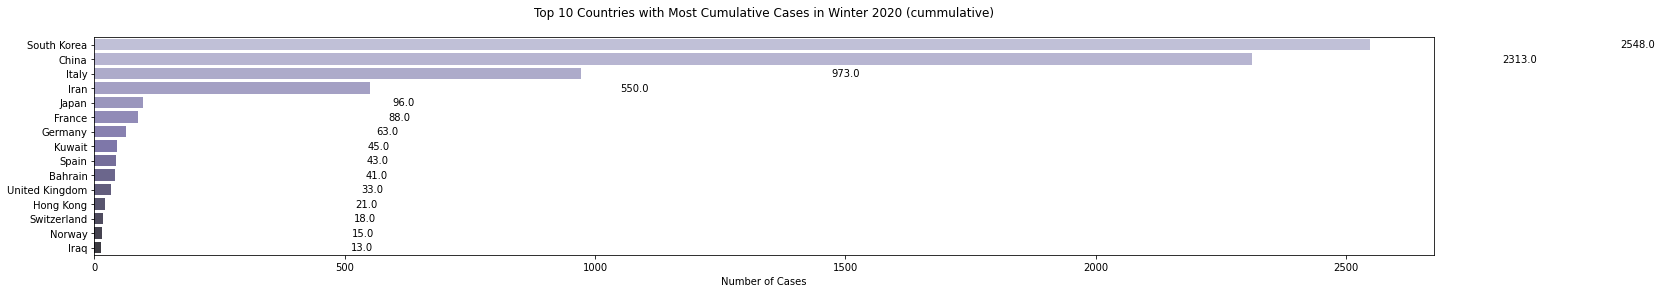

In [0]:
cumm_data = cummulative_winter_newcases_by_2020.sort(cummulative_winter_newcases_by_2020.cummulative.desc()).toPandas()


fig, ax = plt.subplots(figsize=(24,4))
ax = sns.barplot(x="cummulative", y="location", data= cumm_data.head(15), palette="Purples_d")
for index, values in enumerate(cumm_data.head(15).cummulative.values):
    ax.text(values+500,index,str(values),va="center")
title = "Top 10 Countries with Most Cumulative Cases in Winter 2020 (" + cumm_data.columns[-1] +")\n"
ax.set_title(title)
ax.set_xlabel("Number of Cases")
ax.set_ylabel("")
plt.show()

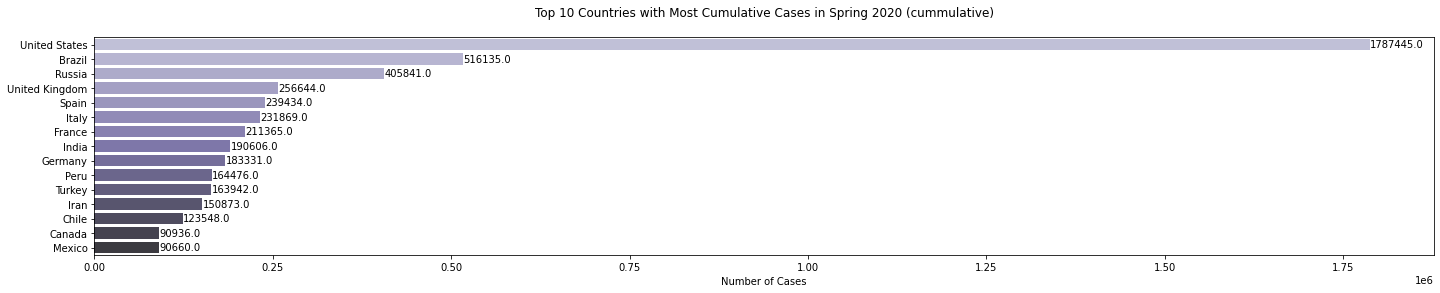

In [0]:
cumm_data = cummulative_spring_newcases_by_2020.sort(cummulative_spring_newcases_by_2020.cummulative.desc()).toPandas()

fig, ax = plt.subplots(figsize=(24,4))
ax = sns.barplot(x="cummulative", y="location", data= cumm_data.head(15), palette="Purples_d")
for index, values in enumerate(cumm_data.head(15).cummulative.values):
    ax.text(values+500,index,str(values),va="center")
title = "Top 10 Countries with Most Cumulative Cases in Spring 2020 (" + cumm_data.columns[-1] +")\n"
ax.set_title(title)
ax.set_xlabel("Number of Cases")
ax.set_ylabel("")
plt.show()

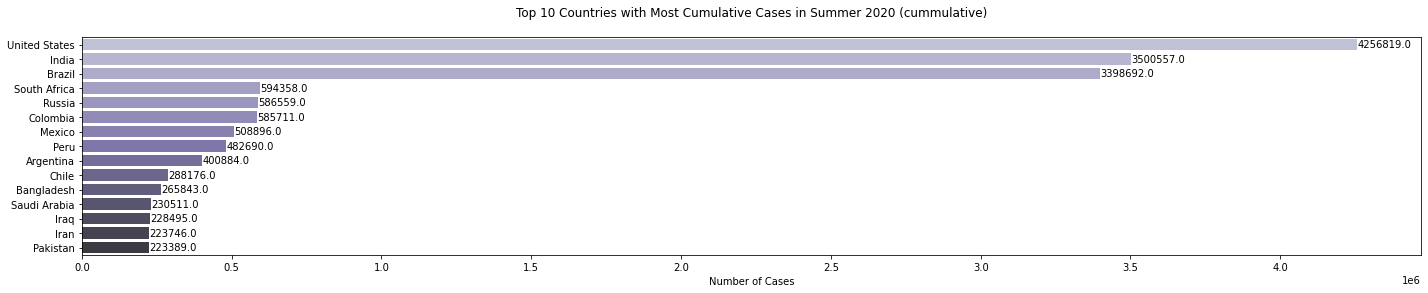

In [0]:
cumm_data = cummulative_summer_newcases_by_2020.sort(cummulative_summer_newcases_by_2020.cummulative.desc()).toPandas()
# cumm_data = cummulative_summer_newcases_by_2020.toPandas()

fig, ax = plt.subplots(figsize=(24,4))
ax = sns.barplot(x="cummulative", y="location", data= cumm_data.head(15), palette="Purples_d")
for index, values in enumerate(cumm_data.head(15).cummulative.values):
    ax.text(values+500,index,str(values),va="center")
title = "Top 10 Countries with Most Cumulative Cases in Summer 2020 (" + cumm_data.columns[-1] +")\n"
ax.set_title(title)
ax.set_xlabel("Number of Cases")
ax.set_ylabel("")
plt.show()

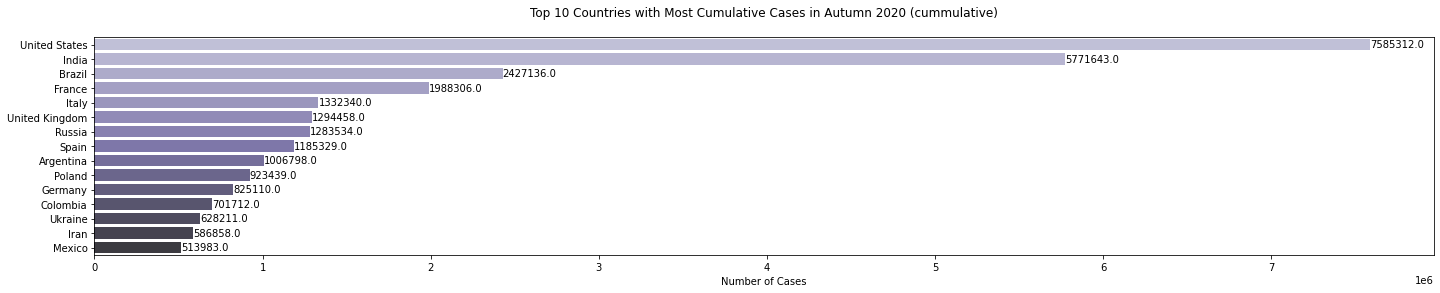

In [0]:
cumm_data = cummulative_autumn_newcases_by_2020.sort(cummulative_autumn_newcases_by_2020.cummulative.desc()).toPandas()

# cumm_data = cummulative_autumn_newcases_by_2020.toPandas()

fig, ax = plt.subplots(figsize=(24,4))
ax = sns.barplot(x="cummulative", y="location", data= cumm_data.head(15), palette="Purples_d")
for index, values in enumerate(cumm_data.head(15).cummulative.values):
    ax.text(values+500,index,str(values),va="center")
title = "Top 10 Countries with Most Cumulative Cases in Autumn 2020 (" + cumm_data.columns[-1] +")\n"
ax.set_title(title)
ax.set_xlabel("Number of Cases")
ax.set_ylabel("")
plt.show()

In [0]:
##REDUCE WEATHER DATASET DROPPING UNNEEDED COLUMNS
max_temp_df = max_temp_df.drop("Province/State", "Lat", "Long")


In [0]:
#####DATA TRANSPOITION#######
## CONVERT ALL DATA COLS TO A DTYPE IN PREPARATION TO TRANSPOSE THE WEATHER DATA
from pyspark.sql.functions import col
# min_temp_df.createOrReplaceTempView("table")
# transposed_min_temp_df = spark.sql("SELECT * from table")
# transposed_min_temp_df = transposed_min_temp_df.select([col(c).cast("string") for c in transposed_min_temp_df.columns])


max_temp_df.createOrReplaceTempView("table2")
transposed_max_temp_df = spark.sql("SELECT * from table2")
transposed_max_temp_df = transposed_max_temp_df.select([col(c).cast("string") for c in transposed_max_temp_df.columns])


In [0]:
###to_explode DEFINES A TRANSPOSE FUNCTION PYSPARK FUNCTIONS
from pyspark.sql.functions import col, explode, array, struct, expr, sum, lit        

def to_explode(df, by):

    # Filter dtypes and split into column names and type description
    cols, dtypes = zip(*((c, t) for (c, t) in df.dtypes if c not in by))
    # Spark SQL supports only homogeneous columns
    assert len(set(dtypes)) == 1, "All columns have to be of the same type"

    # Create and explode an array of (column_name, column_value) structs
    kvs = explode(array([
      struct(lit(c).alias("Date"), col(c).alias("temperature")) for c in cols
    ])).alias("kvs")

    return df.select(by + [kvs]).select(by + ["kvs.Date", "kvs.temperature"])

In [0]:
##TRANSPOSE TEMP DATA AND CHANGE HEADER NAMES TO MATCH COVID DATA###
transposed_max_temp_df = to_explode(transposed_max_temp_df, ['Country/Region'])
transposed_max_temp_df = transposed_max_temp_df.withColumnRenamed("Country/Region", "location")
transposed_max_temp_df.show(1)

+-----------+------+-----------+
|   location|  Date|temperature|
+-----------+------+-----------+
|Afghanistan|1/1/20|         -8|
+-----------+------+-----------+
only showing top 1 row



In [0]:
###REVERT NEEDED TYPES BACK TO REQUIRED FORMAT
from pyspark.sql.types import IntegerType, DoubleType
transposed_max_temp_df = transposed_max_temp_df.withColumn("temperature", transposed_max_temp_df["temperature"].cast(DoubleType()))
# data_df.printSchema()
transposed_max_temp_df.tail(10)

Out[107]: [Row(location='Zimbabwe', Date='9/6/20', temperature=26.29),
 Row(location='Zimbabwe', Date='9/7/20', temperature=27.43),
 Row(location='Zimbabwe', Date='9/8/20', temperature=27.26),
 Row(location='Zimbabwe', Date='9/9/20', temperature=26.62),
 Row(location='Zimbabwe', Date='9/10/20', temperature=26.99),
 Row(location='Zimbabwe', Date='9/11/20', temperature=26.72),
 Row(location='Zimbabwe', Date='9/12/20', temperature=26.56),
 Row(location='Zimbabwe', Date='9/13/20', temperature=26.41),
 Row(location='Zimbabwe', Date='9/14/20', temperature=28.4),
 Row(location='Zimbabwe', Date='9/15/20', temperature=32.31)]

In [0]:
####FILTER TEMPERATURE DATA INTO SEASONS FRAMES
winter_max_temp_2020 = transposed_max_temp_df.filter(transposed_max_temp_df.Date.between('1/1/20','2/31/20'))
spring_max_temp_2020 = transposed_max_temp_df.filter(transposed_max_temp_df.Date.between('3/1/20','5/31/20'))
summer_max_temp_2020 = transposed_max_temp_df.filter(transposed_max_temp_df.Date.between('6/1/20','8/31/20'))
autumn_max_temp_2020 = transposed_max_temp_df.filter(transposed_max_temp_df.Date.between('9/1/20','9/31/20'))
autumn_max_temp_2020.show(5)

+-----------+-------+-----------+
|   location|   Date|temperature|
+-----------+-------+-----------+
|Afghanistan| 9/1/20|      20.38|
|Afghanistan| 9/2/20|      20.38|
|Afghanistan| 9/3/20|      19.06|
|Afghanistan|9/10/20|      18.64|
|Afghanistan|9/11/20|      17.49|
+-----------+-------+-----------+
only showing top 5 rows



In [0]:
## GET THE MEAN MAX TEMP ACOSS SEASONS AND GROUP DATA BY LOCATION
from pyspark.sql.functions import  round
winter_mean_temp_2020 = winter_max_temp_2020.groupby("location").agg(round(sf.mean('temperature')).alias('temperature'))
spring_mean_temp_2020 = spring_max_temp_2020.groupby("location").agg(round(sf.mean('temperature')).alias('temperature'))
summer_mean_temp_2020 = summer_max_temp_2020.groupby("location").agg(round(sf.mean('temperature')).alias('temperature'))
autumn_mean_temp_2020 = autumn_max_temp_2020.groupby("location").agg(round(sf.mean('temperature')).alias('temperature'))


winter_mean_temp_2020.show(3)

+--------+-----------+
|location|temperature|
+--------+-----------+
|    Chad|       30.0|
|Paraguay|       35.0|
|  Russia|      -13.0|
+--------+-----------+
only showing top 3 rows



In [0]:
####DATA JOINS OPERATION #####

In [0]:
###JOIN COVID AND TEMPDATA FOR EACH SEASON

total_winter_data = cummulative_winter_newcases_by_2020.join(winter_mean_temp_2020, on = "location")
total_spring_data = cummulative_spring_newcases_by_2020.join(spring_mean_temp_2020, on = "location")
total_summer_data = cummulative_summer_newcases_by_2020.join(summer_mean_temp_2020, on = "location")
total_autumn_data = cummulative_autumn_newcases_by_2020.join(autumn_mean_temp_2020, on = "location")

total_autumn_data.head(2)

Out[111]: [Row(location='Afghanistan', cummulative=7967.0, temperature=18.0),
 Row(location='Algeria', cummulative=38705.0, temperature=40.0)]

In [0]:
###JOINT DATA VISUALIZATIONS####

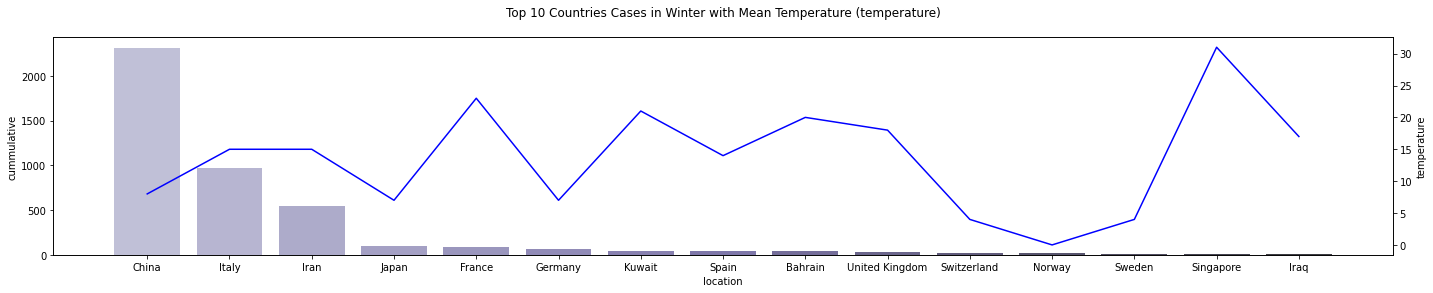

In [0]:
total_winter_data = total_winter_data.sort(total_winter_data.cummulative.desc()).toPandas()
##plot1
fig, ax = plt.subplots(figsize=(24,4))
ax = sns.barplot(x="location", y="cummulative", data= total_winter_data.head(15), palette="Purples_d")

ax2 = plt.twinx()
sns.lineplot(data=total_winter_data.temperature.head(15), color="b", ax=ax2)
# for index, values in enumerate(total_winter_data.temperature.head(15)):
#     ax2.text(values +100,index,str(values),va="center")
title = "Top 10 Countries Cases in Winter with Mean Temperature (" + total_winter_data.columns[-1] +")\n"
ax.set_title(title)
plt.show()


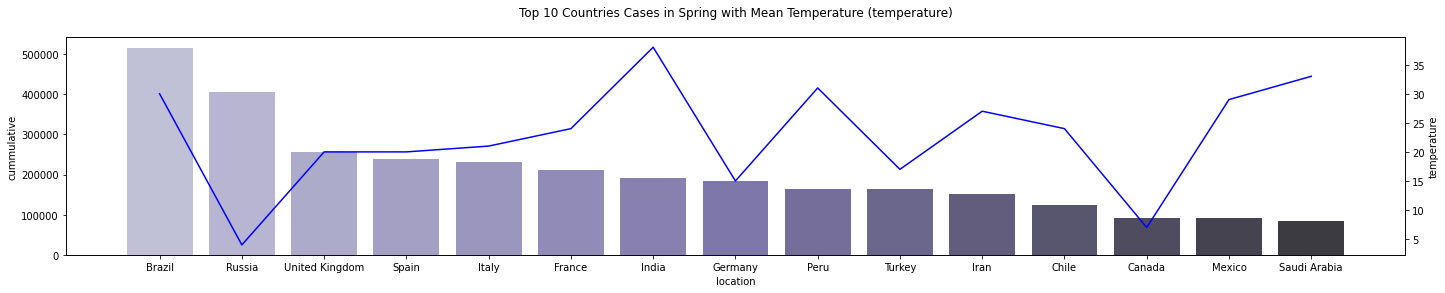

In [0]:

total_spring_data = total_spring_data.sort(total_spring_data.cummulative.desc()).toPandas()
##plot1
fig, ax = plt.subplots(figsize=(24,4))
ax = sns.barplot(x="location", y="cummulative", data= total_spring_data.head(15), palette="Purples_d")

ax2 = plt.twinx()
sns.lineplot(data=total_spring_data.temperature.head(15), color="b", ax=ax2)
# for index, values in enumerate(total_winter_data.temperature.head(15)):
#     ax2.text(values +100,index,str(values),va="center")
title = "Top 10 Countries Cases in Spring with Mean Temperature (" + total_spring_data.columns[-1] +")\n"
ax.set_title(title)
plt.show()

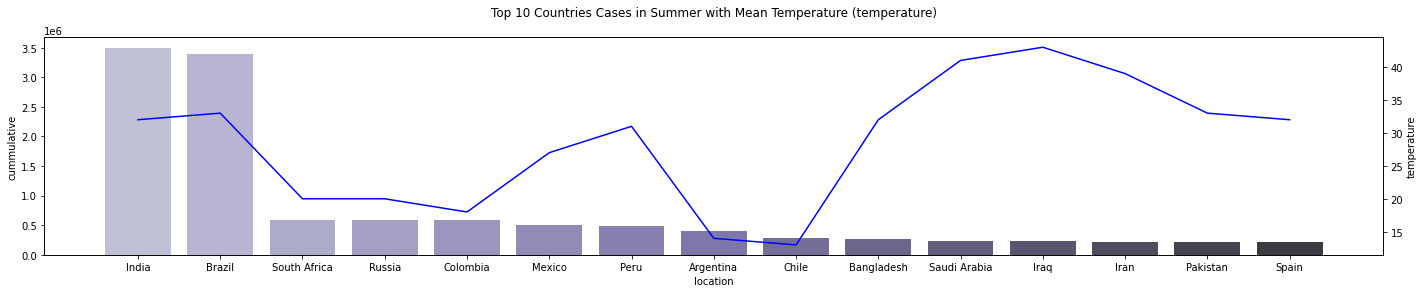

In [0]:
total_summer_data = total_summer_data.sort(total_summer_data.cummulative.desc()).toPandas()


##plot1
fig, ax = plt.subplots(figsize=(24,4))
ax = sns.barplot(x="location", y="cummulative", data= total_summer_data.head(15), palette="Purples_d")

ax2 = plt.twinx()
sns.lineplot(data=total_summer_data.temperature.head(15), color="b", ax=ax2)
# for index, values in enumerate(total_winter_data.temperature.head(15)):
#     ax2.text(values +100,index,str(values),va="center")
title = "Top 10 Countries Cases in Summer with Mean Temperature (" + total_summer_data.columns[-1] +")\n"
ax.set_title(title)
plt.show()

+-------------------+-----------+-----------+
|           location|cummulative|temperature|
+-------------------+-----------+-----------+
|        Afghanistan|     7967.0|       18.0|
|            Algeria|    38705.0|       40.0|
|          Argentina|  1006798.0|       19.0|
|             Angola|    12485.0|       32.0|
|            Belgium|   492109.0|       25.0|
|            Albania|    28669.0|       32.0|
|              Benin|      870.0|       28.0|
|            Bahamas|     5324.0|       32.0|
|            Belarus|    64804.0|       20.0|
|            Andorra|     5569.0|       25.0|
|            Bolivia|    28110.0|       35.0|
|         Bangladesh|   151936.0|       33.0|
|           Barbados|      102.0|       30.0|
|             Bhutan|      185.0|       19.0|
|         Azerbaijan|    84741.0|       33.0|
|            Armenia|    91343.0|       20.0|
|             Brunei|        6.0|       31.0|
|             Belize|     4847.0|       33.0|
|             Brazil|  2427136.0| 

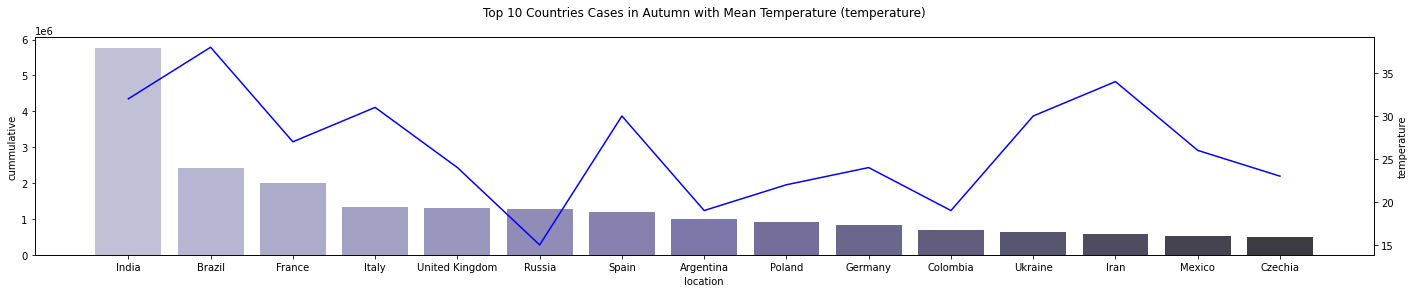

In [0]:
total_autumn_data.show()
total_autumn_data = total_autumn_data.sort(total_autumn_data.cummulative.desc()).toPandas()


##plot1
fig, ax = plt.subplots(figsize=(24,4))
ax = sns.barplot(x="location", y="cummulative", data= total_autumn_data.head(15), palette="Purples_d")

ax2 = plt.twinx()
sns.lineplot(data=total_autumn_data.temperature.head(15), color="b", ax=ax2)
# for index, values in enumerate(total_winter_data.temperature.head(15)):
#     ax2.text(values +100,index,str(values),va="center")
title = "Top 10 Countries Cases in Autumn with Mean Temperature (" + total_autumn_data.columns[-1] +")\n"
ax.set_title(title)
plt.show()

In [0]:
unfiltered_temp_data = transposed_max_temp_df
# unfiltered_temp_data.drop('Date')

unfiltered_temp_data = unfiltered_temp_data.groupby("location").agg(round(sf.mean('temperature')).alias('temperature'))
unfiltered_temp_data.show(5)


+--------+-----------+
|location|temperature|
+--------+-----------+
|    Chad|       37.0|
|Paraguay|       31.0|
|  Russia|        7.0|
|   Yemen|       35.0|
| Senegal|       37.0|
+--------+-----------+
only showing top 5 rows



In [0]:
cummulative_dailynewcases_2021_data = dailynewcases_2021_data.groupby("location").agg(sf.sum('new_cases').alias('cummulative'))
all_data_2020 = cummulative_dailynewcases_2021_data.join(unfiltered_temp_data, on = "location")
all_data_2020.show(5)


+-----------+-----------+-----------+
|   location|cummulative|temperature|
+-----------+-----------+-----------+
|Afghanistan|   105754.0|        7.0|
|    Algeria|   118822.0|       34.0|
|  Argentina|  4028894.0|       22.0|
|     Angola|    64040.0|       29.0|
|    Belgium|  1458847.0|       18.0|
+-----------+-----------+-----------+
only showing top 5 rows



In [0]:
##################################MODELING##############################

In [0]:
# machine learning
import tensorflow as tf


In [0]:
all_data_2020 = all_data_2020.drop('location')
data_m1 = all_data_2020.toPandas()
data_m2 = data_m1.to_numpy()

# data_m2.head()
points = data_m2                            # data which we want to cluster (exclude the country name)

def input_fn():
    return tf.compat.v1.train.limit_epochs(tf.convert_to_tensor(points, dtype=tf.float32), num_epochs=1)      # converting array to tensor

num_clusters = 4                                                                                              # number of cluster, in this chance we use 4 cluster
kmeans = tf.compat.v1.estimator.experimental.KMeans(num_clusters=num_clusters, use_mini_batch=False)          # build the KMeans cluster object from tensorflow

# # train
num_iterations = 50                                                                                           # 50 iteration to find the cluster centroid
previous_centers = None
for _ in range(num_iterations):
    kmeans.train(input_fn)                                                                                    # fit the model into the data
    
# # map the input points to their clusters
cluster_indices = list(kmeans.predict_cluster_index(input_fn)) 

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpxxa9zl0a', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:ten